# Tarea Final

In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from Paquetes.HelperFunctions import violin_plot_numeric, null_percentage, value_counts_all_cols, train_models, validate_models
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
from tqdm import tqdm
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, GroupKFold, RepeatedStratifiedKFold
import lightgbm as lgb
from sklearn.metrics import log_loss
import xgboost as xgb
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier
import joblib

# %matplotlib notebook


In [2]:
# https://www.kaggle.com/competitions/playground-series-s3e26/data?select=train.csv
# Load Dataset
df = pd.read_csv('data/train.csv')
df.head()


test_real_df = pd.read_csv('data/test.csv')
submission_df = pd.read_csv('data/submission.csv')

In [3]:
df['Status'].value_counts()

Status
C     4965
D     2665
CL     275
Name: count, dtype: int64

## Split Data

In [4]:
from sklearn.model_selection import train_test_split


# Use train_test_split to split the DataFrame
train_df, test_df = train_test_split(df, test_size=0.3, stratify=df['Status'])

test_IDs = test_df.id
test_IDs_real = test_real_df.id

# # Drop ID column
train_df.drop(columns=['id'], inplace=True)
test_df.drop(columns=['id'], inplace=True)
test_real_df.drop(columns=['id'], inplace=True)



In [5]:
test_real_df.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,3839,D-penicillamine,19724,F,N,Y,N,N,1.2,546.0,3.37,65.0,1636.0,151.90,90.0,430.0,10.6,2.0
1,2468,D-penicillamine,14975,F,N,N,N,N,1.1,660.0,4.22,94.0,1257.0,151.90,155.0,227.0,10.0,2.0
2,51,Placebo,13149,F,N,Y,N,Y,2.0,151.0,2.96,46.0,961.0,69.75,101.0,213.0,13.0,4.0
3,2330,D-penicillamine,20510,F,N,N,N,N,0.6,293.0,3.85,40.0,554.0,125.55,56.0,270.0,10.6,2.0
4,1615,D-penicillamine,21904,F,N,Y,N,N,1.4,277.0,2.97,121.0,1110.0,125.00,126.0,221.0,9.8,1.0


## EDA

In [6]:
train_df.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
5318,1234,D-penicillamine,21464,M,N,Y,N,N,0.5,400.0,3.46,152.0,1718.0,137.95,171.0,190.0,10.0,3.0,C
1696,2318,D-penicillamine,20233,F,N,Y,Y,N,1.1,347.0,3.19,105.0,1758.0,170.50,90.0,139.0,11.0,4.0,C
465,1810,D-penicillamine,20555,F,N,Y,Y,N,3.3,361.0,3.57,34.0,12258.8,72.85,104.0,341.0,10.6,4.0,C
6764,3149,D-penicillamine,11463,F,N,N,N,N,0.7,298.0,3.67,25.0,663.0,71.30,66.0,251.0,10.0,2.0,C
7073,2796,D-penicillamine,22881,F,N,N,N,N,1.5,239.0,3.77,77.0,598.0,97.65,101.0,312.0,10.2,1.0,D


In [7]:
train_df.shape

(5533, 19)

In [8]:
test_df.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
1950,3358,Placebo,17246,F,N,Y,N,N,5.0,1336.0,3.51,154.0,2045.0,203.05,133.0,225.0,13.3,4.0,D
2558,1882,Placebo,12120,F,N,Y,N,N,0.8,578.0,3.35,29.0,1877.0,93.00,111.0,231.0,9.8,3.0,C
1002,4556,D-penicillamine,17850,F,N,N,N,N,0.6,132.0,3.66,12.0,5300.0,52.70,64.0,303.0,10.0,1.0,C
5577,2419,D-penicillamine,13344,F,N,N,N,N,1.3,294.0,3.37,73.0,2039.0,232.50,69.0,380.0,11.0,3.0,C
2079,1785,Placebo,13486,F,N,N,N,N,0.5,219.0,3.65,52.0,637.0,45.00,85.0,326.0,9.9,3.0,C


In [9]:
test_df.shape

(2372, 19)

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5533 entries, 5318 to 7250
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         5533 non-null   int64  
 1   Drug           5533 non-null   object 
 2   Age            5533 non-null   int64  
 3   Sex            5533 non-null   object 
 4   Ascites        5533 non-null   object 
 5   Hepatomegaly   5533 non-null   object 
 6   Spiders        5533 non-null   object 
 7   Edema          5533 non-null   object 
 8   Bilirubin      5533 non-null   float64
 9   Cholesterol    5533 non-null   float64
 10  Albumin        5533 non-null   float64
 11  Copper         5533 non-null   float64
 12  Alk_Phos       5533 non-null   float64
 13  SGOT           5533 non-null   float64
 14  Tryglicerides  5533 non-null   float64
 15  Platelets      5533 non-null   float64
 16  Prothrombin    5533 non-null   float64
 17  Stage          5533 non-null   float64
 18  Status    

### Check Numerical Cols

In [11]:
numeric_cols = train_df.select_dtypes(include='number')
print(len(numeric_cols.columns))

12


In [12]:
print(type(numeric_cols))

<class 'pandas.core.frame.DataFrame'>


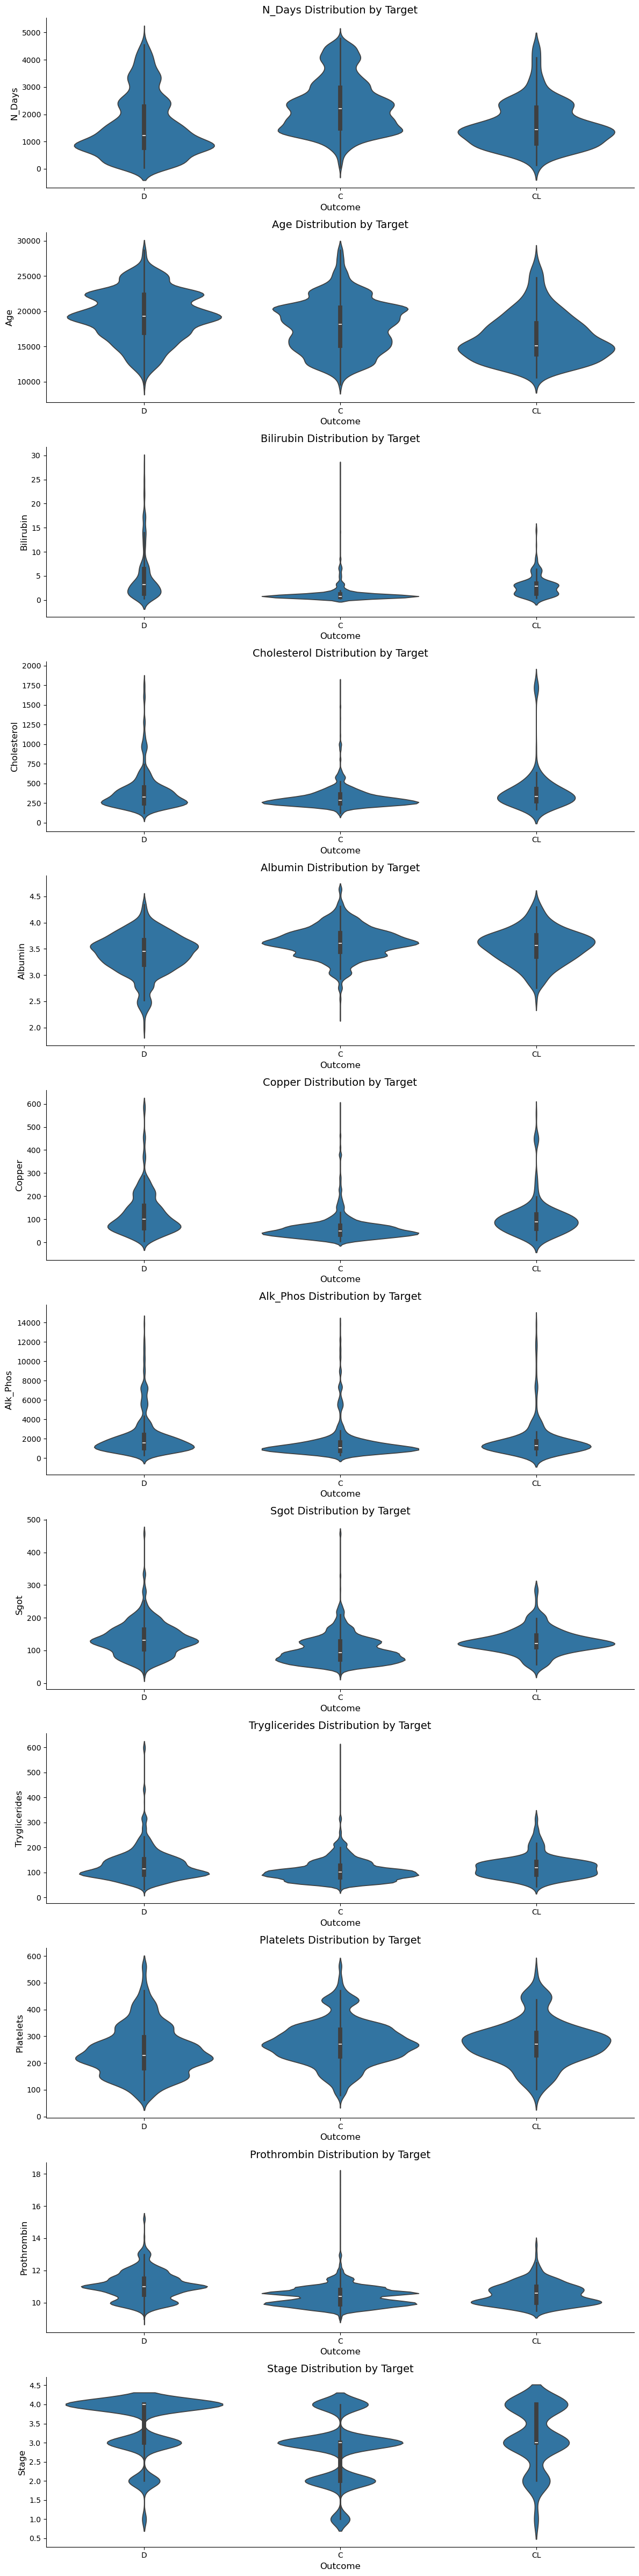

In [13]:
violin_plot_numeric(df, numeric_cols)

### Check Categorical Columns

In [14]:
cat_cols = train_df.select_dtypes(include='object')
cat_cols

,Drug,Sex,Ascites,Hepatomegaly,Spiders,Edema,Status
5318,D-penicillamine,M,N,Y,N,N,C
1696,D-penicillamine,F,N,Y,Y,N,C
465,D-penicillamine,F,N,Y,Y,N,C
6764,D-penicillamine,F,N,N,N,N,C
7073,D-penicillamine,F,N,N,N,N,D
...,...,...,...,...,...,...,...
2100,Placebo,F,N,N,N,N,C
3001,D-penicillamine,F,N,N,N,N,C
5528,Placebo,F,N,Y,N,N,D
7538,Placebo,F,N,N,Y,N,D


In [15]:
value_counts_all_cols(cat_cols)

Value Counts for : Drug
Placebo            2786
D-penicillamine    2747
Name: count, dtype: int64

Value Counts for : Sex
F    5152
M     381
Name: count, dtype: int64

Value Counts for : Ascites
N    5272
Y     261
Name: count, dtype: int64

Value Counts for : Hepatomegaly
Y    2820
N    2713
Name: count, dtype: int64

Value Counts for : Spiders
N    4144
Y    1389
Name: count, dtype: int64

Value Counts for : Edema
N    5020
S     271
Y     242
Name: count, dtype: int64

Value Counts for : Status
C     3475
D     1865
CL     193
Name: count, dtype: int64



* Drug: One-Hot Encoding
* Sex: Label encoding
* Ascites: Label Encoding
* Hepatomegaly: Label Encoding
* Spiders: Label Encoding
* Edema: One-Hot Encoding
* Status: Label Encoding

## Limpieza y Preprocesamiento de Datos

### Identificación y manejo de valores faltantes

In [16]:
null_percentage(train_df)

N_Days: total -> 0, percentage -> 0.00%
Drug: total -> 0, percentage -> 0.00%
Age: total -> 0, percentage -> 0.00%
Sex: total -> 0, percentage -> 0.00%
Ascites: total -> 0, percentage -> 0.00%
Hepatomegaly: total -> 0, percentage -> 0.00%
Spiders: total -> 0, percentage -> 0.00%
Edema: total -> 0, percentage -> 0.00%
Bilirubin: total -> 0, percentage -> 0.00%
Cholesterol: total -> 0, percentage -> 0.00%
Albumin: total -> 0, percentage -> 0.00%
Copper: total -> 0, percentage -> 0.00%
Alk_Phos: total -> 0, percentage -> 0.00%
SGOT: total -> 0, percentage -> 0.00%
Tryglicerides: total -> 0, percentage -> 0.00%
Platelets: total -> 0, percentage -> 0.00%
Prothrombin: total -> 0, percentage -> 0.00%
Stage: total -> 0, percentage -> 0.00%
Status: total -> 0, percentage -> 0.00%


* No null values in the training set

### Codificación de variable categoricas

#### One-Hot Encoding

In [17]:
from Paquetes.HelperFunctions import one_hot_encoding
one_hot_cols = ['Edema']

train_df = one_hot_encoding(train_df, one_hot_cols)
test_df = one_hot_encoding(test_df, one_hot_cols)
test_real_df = one_hot_encoding(test_real_df, one_hot_cols)

In [18]:
test_real_df.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Edema_N,Edema_S,Edema_Y
0,3839,D-penicillamine,19724,F,N,Y,N,1.2,546.0,3.37,65.0,1636.0,151.90,90.0,430.0,10.6,2.0,True,False,False
1,2468,D-penicillamine,14975,F,N,N,N,1.1,660.0,4.22,94.0,1257.0,151.90,155.0,227.0,10.0,2.0,True,False,False
2,51,Placebo,13149,F,N,Y,N,2.0,151.0,2.96,46.0,961.0,69.75,101.0,213.0,13.0,4.0,False,False,True
3,2330,D-penicillamine,20510,F,N,N,N,0.6,293.0,3.85,40.0,554.0,125.55,56.0,270.0,10.6,2.0,True,False,False
4,1615,D-penicillamine,21904,F,N,Y,N,1.4,277.0,2.97,121.0,1110.0,125.00,126.0,221.0,9.8,1.0,True,False,False


#### Label Encoding

In [19]:
le_cols = ['Drug','Sex','Ascites', 'Hepatomegaly', 'Spiders', 'Status']
value_counts_all_cols(train_df, le_cols)

Value Counts for : Drug
Placebo            2786
D-penicillamine    2747
Name: count, dtype: int64

Value Counts for : Sex
F    5152
M     381
Name: count, dtype: int64

Value Counts for : Ascites
N    5272
Y     261
Name: count, dtype: int64

Value Counts for : Hepatomegaly
Y    2820
N    2713
Name: count, dtype: int64

Value Counts for : Spiders
N    4144
Y    1389
Name: count, dtype: int64

Value Counts for : Status
C     3475
D     1865
CL     193
Name: count, dtype: int64



In [20]:
from Paquetes.HelperFunctions import label_encoding


le_cols = ['Drug','Sex','Ascites', 'Hepatomegaly', 'Spiders', 'Status']
le_cols_test_real = ['Drug','Sex','Ascites', 'Hepatomegaly', 'Spiders']
cols_dict = {'Drug': {'D-penicillamine': 0, 'Placebo': 1}, 'Sex': {"F":0,"M":1}, 'Ascites':{'N':0,'Y':1}, 'Hepatomegaly': {'N':0,'Y':1}, 'Spiders': {'N':0,'Y':1}, 'Status': {'C':0,'D':1,'CL':2} }
cols_dict_test_real = {'Drug': {'D-penicillamine': 0, 'Placebo': 1}, 'Sex': {"F":0,"M":1}, 'Ascites':{'N':0,'Y':1}, 'Hepatomegaly': {'N':0,'Y':1}, 'Spiders': {'N':0,'Y':1} }
label_encoding(train_df, le_cols, cols_dict)
label_encoding(test_df, le_cols, cols_dict)
label_encoding(test_real_df, le_cols_test_real, cols_dict_test_real)


,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Edema_N,Edema_S,Edema_Y
0,3839,0,19724,0,0,1,0,1.2,546.0,3.37,65.0,1636.0,151.90,90.0,430.0,10.6,2.0,True,False,False
1,2468,0,14975,0,0,0,0,1.1,660.0,4.22,94.0,1257.0,151.90,155.0,227.0,10.0,2.0,True,False,False
2,51,1,13149,0,0,1,0,2.0,151.0,2.96,46.0,961.0,69.75,101.0,213.0,13.0,4.0,False,False,True
3,2330,0,20510,0,0,0,0,0.6,293.0,3.85,40.0,554.0,125.55,56.0,270.0,10.6,2.0,True,False,False
4,1615,0,21904,0,0,1,0,1.4,277.0,2.97,121.0,1110.0,125.00,126.0,221.0,9.8,1.0,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5266,2870,1,12279,0,0,0,0,1.3,302.0,3.43,75.0,1345.0,145.00,44.0,181.0,10.6,3.0,True,False,False
5267,1770,1,24803,0,0,0,0,0.5,219.0,4.09,121.0,663.0,79.05,94.0,311.0,9.7,3.0,True,False,False
5268,3707,0,16990,0,0,1,0,0.8,315.0,4.09,13.0,1637.0,170.50,70.0,426.0,10.9,3.0,True,False,False
5269,1216,1,11773,0,0,0,0,0.7,329.0,3.80,52.0,678.0,57.00,126.0,306.0,10.2,1.0,True,False,False


In [21]:
le_cols = ['Drug','Sex','Ascites', 'Hepatomegaly', 'Spiders', 'Status']
value_counts_all_cols(test_real_df, le_cols_test_real)

print(len(train_df))

Value Counts for : Drug
1    2694
0    2577
Name: count, dtype: int64

Value Counts for : Sex
0    4877
1     394
Name: count, dtype: int64

Value Counts for : Ascites
0    5027
1     244
Name: count, dtype: int64

Value Counts for : Hepatomegaly
1    2730
0    2541
Name: count, dtype: int64

Value Counts for : Spiders
0    3972
1    1299
Name: count, dtype: int64

5533


In [22]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5533 entries, 5318 to 7250
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         5533 non-null   int64  
 1   Drug           5533 non-null   int64  
 2   Age            5533 non-null   int64  
 3   Sex            5533 non-null   int64  
 4   Ascites        5533 non-null   int64  
 5   Hepatomegaly   5533 non-null   int64  
 6   Spiders        5533 non-null   int64  
 7   Bilirubin      5533 non-null   float64
 8   Cholesterol    5533 non-null   float64
 9   Albumin        5533 non-null   float64
 10  Copper         5533 non-null   float64
 11  Alk_Phos       5533 non-null   float64
 12  SGOT           5533 non-null   float64
 13  Tryglicerides  5533 non-null   float64
 14  Platelets      5533 non-null   float64
 15  Prothrombin    5533 non-null   float64
 16  Stage          5533 non-null   float64
 17  Status         5533 non-null   int64  
 18  Edema_N   

## Modelado y Evaluación

### Selección de Características

In [23]:
train_df.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,Edema_N,Edema_S,Edema_Y
5318,1234,0,21464,1,0,1,0,0.5,400.0,3.46,152.0,1718.0,137.95,171.0,190.0,10.0,3.0,0,True,False,False
1696,2318,0,20233,0,0,1,1,1.1,347.0,3.19,105.0,1758.0,170.50,90.0,139.0,11.0,4.0,0,True,False,False
465,1810,0,20555,0,0,1,1,3.3,361.0,3.57,34.0,12258.8,72.85,104.0,341.0,10.6,4.0,0,True,False,False
6764,3149,0,11463,0,0,0,0,0.7,298.0,3.67,25.0,663.0,71.30,66.0,251.0,10.0,2.0,0,True,False,False
7073,2796,0,22881,0,0,0,0,1.5,239.0,3.77,77.0,598.0,97.65,101.0,312.0,10.2,1.0,2,True,False,False


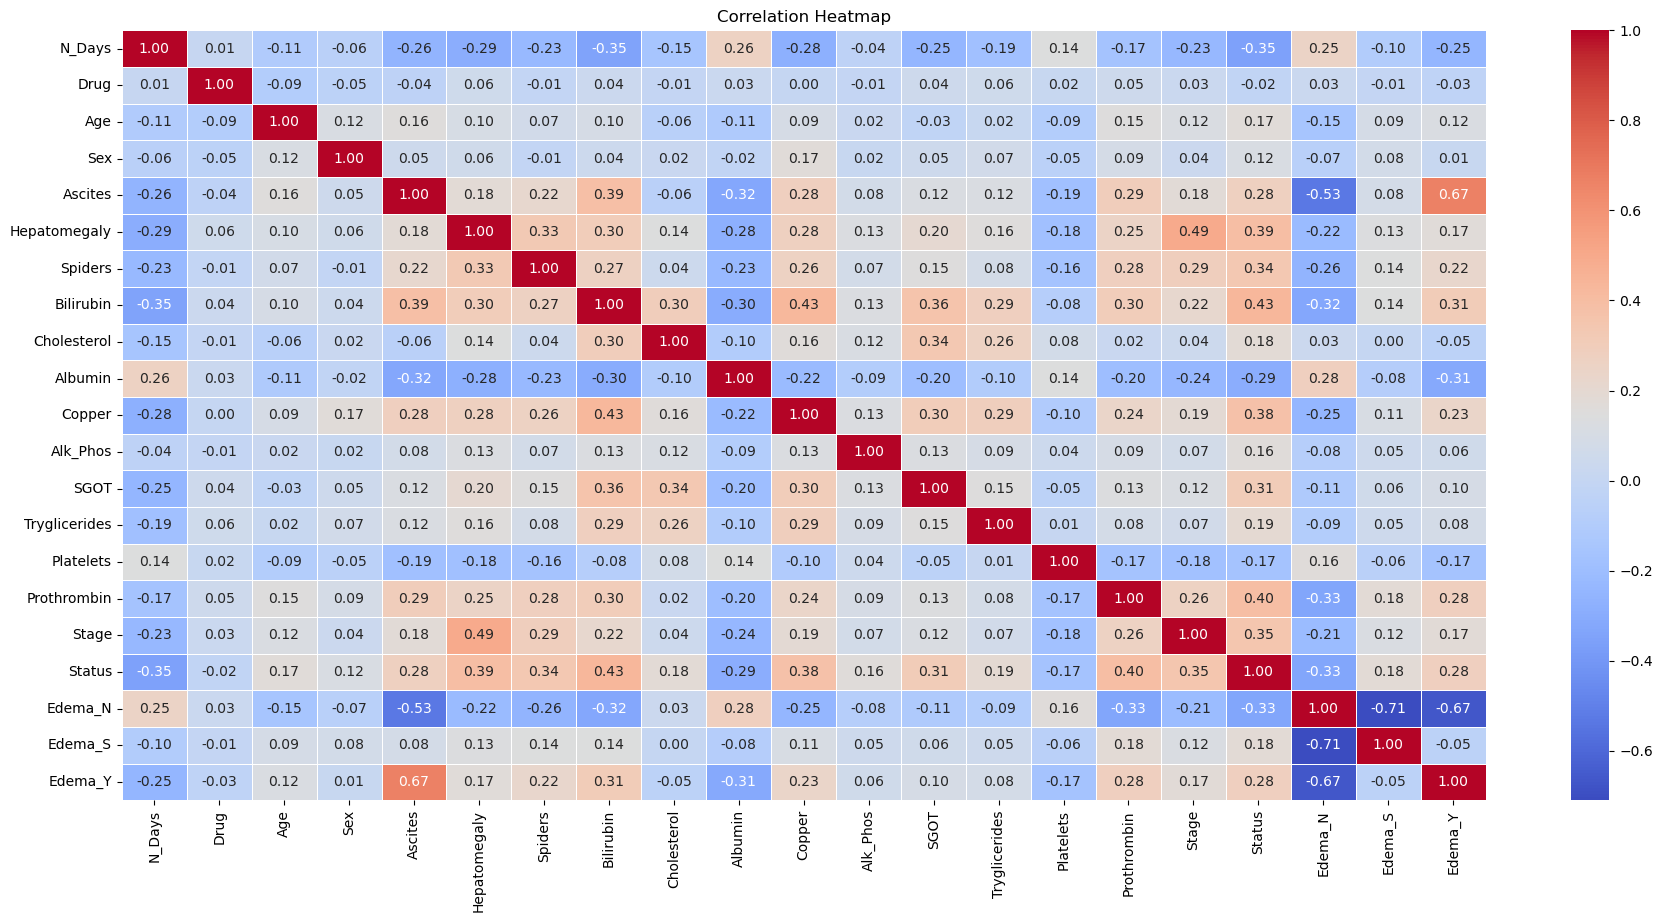

In [24]:
from Paquetes.HelperFunctions import corr_heatmap

corr = corr_heatmap(train_df)

In [25]:
LABEL = "Status"
CAT_FEATS = ["Drug", "Sex", "Ascites", "Hepatomegaly", "Spiders", "Edema", "Stage"]
NUM_FEATS = [x for x in train_df.columns if x not in CAT_FEATS and x != LABEL]

### Feature Engineering

In [26]:

class DiagnosisDateTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Diagnosis_Date'] = X['Age'] - X['N_Days']
        return X
    
class AgeYearsTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Age_Years'] = round(X['Age'] / 365.25).astype("int16")
        return X

class AgeGroupsTransformer(BaseEstimator, TransformerMixin):
    """Older people might be hit harder (interaction) by health issues. Also can cover lifestyle influences, i.e.
    alcohol consumption etc."""
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        # Use years from above, min=26, max=78
        X['Age_Group'] = pd.cut(X['Age_Years'], bins=[19, 29, 49, 64, 99], labels = [0, 1, 2, 3]).astype('int16')
        return X

class BilirubinAlbuminTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Bilirubin_Albumin'] = X['Bilirubin'] * X['Albumin']
        return X

class DrugEffectivenessTransformer(BaseEstimator, TransformerMixin):
    # Placeholder concept, assuming 'Bilirubin' improvement is a measure of effectiveness
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Drug_Effectiveness'] = X['Drug'] * X['Bilirubin']
        return X

class SymptomScoreTransformer(BaseEstimator, TransformerMixin):
    # From data set explanations above let's add all the "bad" symptoms
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        # symptom_columns = ['Ascites', 'Hepatomegaly', 'Spiders', 'Edema']
        symptom_columns = ['Ascites', 'Hepatomegaly', 'Spiders', 'Edema_N', 'Edema_S', 'Edema_Y']
        X['Symptom_Score'] = X[symptom_columns].sum(axis=1)
        return X
    
class SymptomCatTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.symptom_columns = ['Ascites', 'Hepatomegaly', 'Spiders', 'Edema_N', 'Edema_S', 'Edema_Y']
        self.encoder = OneHotEncoder(handle_unknown='ignore')

    def fit(self, X, y=None):
        X_copy = X.copy()
        symptom_scores = X_copy[self.symptom_columns].apply(lambda row: ''.join(row.values.astype(str)), axis=1)
        self.encoder.fit(symptom_scores.values.reshape(-1, 1))
        return self

    def transform(self, X):
        X_transformed = X.copy()
        symptom_scores = X_transformed[self.symptom_columns].apply(lambda row: ''.join(row.values.astype(str)), axis=1)
        encoded_features = self.encoder.transform(symptom_scores.values.reshape(-1, 1)).toarray().astype("int8")
        encoded_feature_names = self.encoder.get_feature_names_out(input_features=['Symptom_Score'])
        # Drop the original symptom columns and add the new encoded features
        # X_transformed.drop(columns=self.symptom_columns, inplace=True)
        X_transformed[encoded_feature_names] = pd.DataFrame(encoded_features, index=X_transformed.index)
        
        return X_transformed


class LiverFunctionTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        liver_columns = ['Bilirubin', 'Albumin', 'Alk_Phos', 'SGOT']
        X['Liver_Function_Index'] = X[liver_columns].mean(axis=1)
        return X

class RiskScoreTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Risk_Score'] = X['Bilirubin'] + X['Albumin'] - X['Alk_Phos']
        return X

class TimeFeaturesTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Diag_Year'] = (X['N_Days'] / 365).astype(int)
        X['Diag_Month'] = ((X['N_Days'] % 365) / 30).astype(int)
        return X
    
class ScalingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()
        self.num_feats = NUM_FEATS + ['Diagnosis_Date', 'Age_Years', 'Bilirubin_Albumin', 'Drug_Effectiveness', 
                                      'Symptom_Score', 'Liver_Function_Index', 'Risk_Score', 'Diag_Year', 'Diag_Month']

    def fit(self, X, y=None):
        self.scaler.fit(X[self.num_feats])
        return self

    def transform(self, X):
        X_scaled = X.copy()
        X_scaled[self.num_feats] = self.scaler.transform(X_scaled[self.num_feats])
        return X_scaled

# Define the pipeline
pipeline = Pipeline([
    ('diagnosis_date', DiagnosisDateTransformer()),
    ('age_years', AgeYearsTransformer()),
    ('age_groups', AgeGroupsTransformer()),
    ('bilirubin_albumin', BilirubinAlbuminTransformer()),
    ('drug_effectiveness', DrugEffectivenessTransformer()),
    ('symptom_score', SymptomScoreTransformer()),
    ('symptom_cat_score', SymptomCatTransformer()),
    ('liver_function', LiverFunctionTransformer()),
    ('risk_score', RiskScoreTransformer()),
    ('time_features', TimeFeaturesTransformer()),
    #('scaling', ScalingTransformer()),
    # ... ?
])

# Apply the pipeline to your dataframes
train_df_mod = pipeline.fit_transform(train_df)
test_df_mod = pipeline.transform(test_df)
test_df_real_mod = pipeline.transform(test_real_df)

train_df_mod['Symptom_Score'] = pd.to_numeric(train_df_mod['Symptom_Score'], errors='coerce')
test_df_mod['Symptom_Score'] = pd.to_numeric(test_df_mod['Symptom_Score'], errors='coerce')
test_df_real_mod['Symptom_Score'] = pd.to_numeric(test_df_real_mod['Symptom_Score'], errors='coerce')

# Update the CAT_FEATS
CAT_FEATS = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage', #old
             'Age_Group', 'Symptom_Score'] # new 
# Update the NUM_FEATS ????

In [27]:
train_df_mod.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,Edema_N,Edema_S,Edema_Y,Diagnosis_Date,Age_Years,Age_Group,Bilirubin_Albumin,Drug_Effectiveness,Symptom_Score,Symptom_Score_000FalseFalseTrue,Symptom_Score_000FalseTrueFalse,Symptom_Score_000TrueFalseFalse,Symptom_Score_001FalseFalseTrue,Symptom_Score_001FalseTrueFalse,Symptom_Score_001TrueFalseFalse,Symptom_Score_010FalseFalseTrue,Symptom_Score_010FalseTrueFalse,Symptom_Score_010TrueFalseFalse,Symptom_Score_011FalseFalseTrue,Symptom_Score_011FalseTrueFalse,Symptom_Score_011TrueFalseFalse,Symptom_Score_100FalseFalseTrue,Symptom_Score_100FalseTrueFalse,Symptom_Score_100TrueFalseFalse,Symptom_Score_101FalseFalseTrue,Symptom_Score_101TrueFalseFalse,Symptom_Score_110FalseFalseTrue,Symptom_Score_110FalseTrueFalse,Symptom_Score_110TrueFalseFalse,Symptom_Score_111FalseFalseTrue,Symptom_Score_111FalseTrueFalse,Symptom_Score_111TrueFalseFalse,Liver_Function_Index,Risk_Score,Diag_Year,Diag_Month
5318,1234,0,21464,1,0,1,0,0.5,400.0,3.46,152.0,1718.0,137.95,171.0,190.0,10.0,3.0,0,True,False,False,20230,59,2,1.730,0.0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,464.9775,-1714.04,3,4
1696,2318,0,20233,0,0,1,1,1.1,347.0,3.19,105.0,1758.0,170.50,90.0,139.0,11.0,4.0,0,True,False,False,17915,55,2,3.509,0.0,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,483.1975,-1753.71,6,4
465,1810,0,20555,0,0,1,1,3.3,361.0,3.57,34.0,12258.8,72.85,104.0,341.0,10.6,4.0,0,True,False,False,18745,56,2,11.781,0.0,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3084.6300,-12251.93,4,11
6764,3149,0,11463,0,0,0,0,0.7,298.0,3.67,25.0,663.0,71.30,66.0,251.0,10.0,2.0,0,True,False,False,8314,31,1,2.569,0.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,184.6675,-658.63,8,7
7073,2796,0,22881,0,0,0,0,1.5,239.0,3.77,77.0,598.0,97.65,101.0,312.0,10.2,1.0,2,True,False,False,20085,63,2,5.655,0.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,175.2300,-592.73,7,8


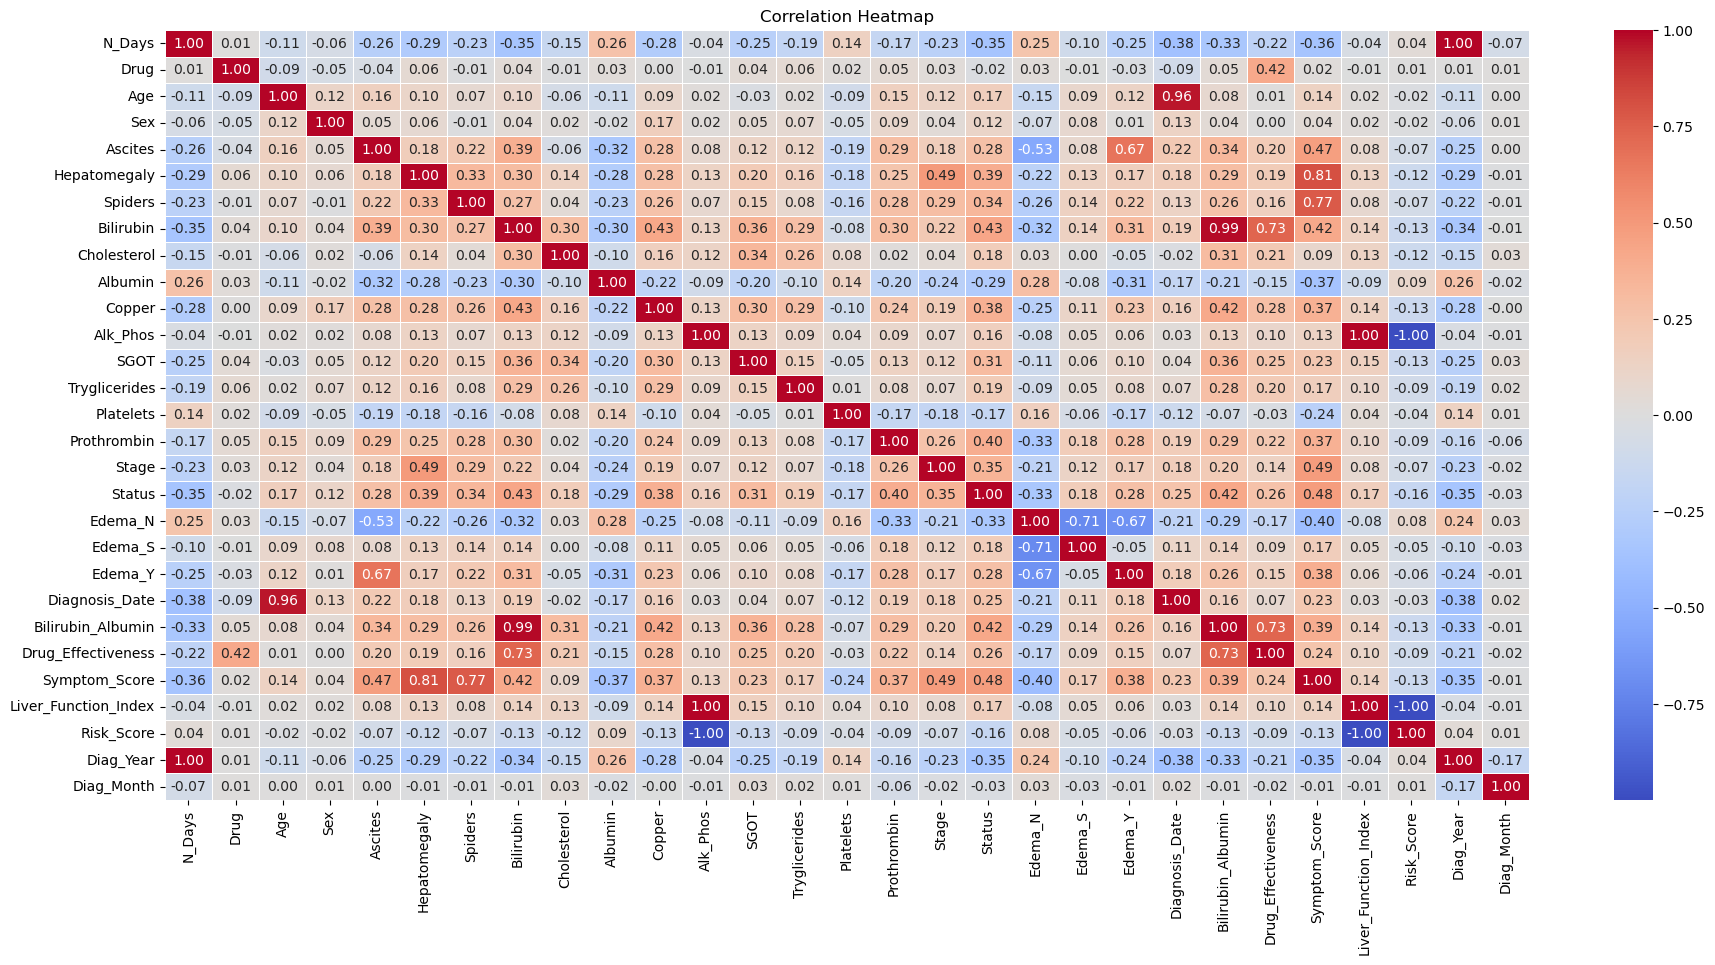

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,Edema_N,Edema_S,Edema_Y,Diagnosis_Date,Bilirubin_Albumin,Drug_Effectiveness,Symptom_Score,Liver_Function_Index,Risk_Score,Diag_Year,Diag_Month
N_Days,1.000000,0.008196,-0.108667,-0.059637,-0.257158,-0.292202,-0.227672,-0.348317,-0.149221,0.260576,-0.281657,-0.037126,-0.246056,-0.186063,0.141072,-0.167650,-0.234027,-0.354201,0.249118,-0.101325,-0.246366,-0.377489,-0.331868,-0.217036,-0.357210,-0.044045,0.036479,0.995428,-0.071975
Drug,0.008196,1.000000,-0.092469,-0.048312,-0.039932,0.057891,-0.009500,0.038120,-0.007905,0.025939,0.003567,-0.006997,0.044991,0.056080,0.017255,0.047110,0.027583,-0.017846,0.026557,-0.007462,-0.029788,-0.088402,0.045550,0.419625,0.019519,-0.005716,0.007080,0.007002,0.012627
Age,-0.108667,-0.092469,1.000000,0.116660,0.155433,0.104870,0.067776,0.095644,-0.063450,-0.109105,0.092302,0.019206,-0.027168,0.017223,-0.091167,0.149706,0.122762,0.165146,-0.151561,0.087179,0.122941,0.961551,0.077321,0.014668,0.136965,0.018596,-0.019037,-0.107571,0.003671
Sex,-0.059637,-0.048312,0.116660,1.000000,0.050593,0.063987,-0.014232,0.039520,0.020325,-0.016835,0.167860,0.015626,0.048822,0.067084,-0.050008,0.086025,0.036336,0.116279,-0.065645,0.077185,0.011643,0.125148,0.043309,0.004513,0.043611,0.016914,-0.015553,-0.060238,0.013670
Ascites,-0.257158,-0.039932,0.155433,0.050593,1.000000,0.179017,0.217205,0.389601,-0.056195,-0.324745,0.281067,0.075531,0.122410,0.119118,-0.186914,0.293001,0.176360,0.276145,-0.531426,0.079854,0.669391,0.215834,0.335159,0.199052,0.472217,0.079152,-0.074822,-0.254264,0.002584
Hepatomegaly,-0.292202,0.057891,0.104870,0.063987,0.179017,1.000000,0.326065,0.299096,0.139901,-0.276513,0.277968,0.125119,0.203088,0.156714,-0.182450,0.249729,0.493440,0.394766,-0.218814,0.133810,0.169108,0.178414,0.289757,0.188619,0.810631,0.130475,-0.124596,-0.287614,-0.011106
Spiders,-0.227672,-0.009500,0.067776,-0.014232,0.217205,0.326065,1.000000,0.269714,0.042364,-0.227934,0.264919,0.073468,0.148540,0.080355,-0.163374,0.279110,0.291345,0.336787,-0.260428,0.142852,0.218582,0.126033,0.259911,0.157431,0.766972,0.077554,-0.072983,-0.223891,-0.010516
Bilirubin,-0.348317,0.038120,0.095644,0.039520,0.389601,0.299096,0.269714,1.000000,0.297195,-0.298341,0.428185,0.128913,0.361408,0.285268,-0.080170,0.301627,0.215236,0.433973,-0.324676,0.143345,0.309178,0.185322,0.988966,0.726708,0.416590,0.139785,-0.126978,-0.343348,-0.006802
Cholesterol,-0.149221,-0.007905,-0.063450,0.020325,-0.056195,0.139901,0.042364,0.297195,1.000000,-0.096357,0.158589,0.117816,0.336170,0.260758,0.076563,0.018393,0.041928,0.184056,0.032686,0.001908,-0.048368,-0.017882,0.309488,0.211679,0.091170,0.126697,-0.117262,-0.150849,0.034433
Albumin,0.260576,0.025939,-0.109105,-0.016835,-0.324745,-0.276513,-0.227934,-0.298341,-0.096357,1.000000,-0.217386,-0.088748,-0.197849,-0.098489,0.138799,-0.201393,-0.240962,-0.292606,0.281423,-0.084261,-0.310188,-0.173622,-0.212781,-0.150235,-0.365086,-0.093975,0.088349,0.259791,-0.024044


In [28]:
corr_heatmap(train_df_mod)

In [29]:
label_encoder = LabelEncoder()
def tsne_with_feature_selection_and_pca(data, num_feats, target_column, n_components=2, top_n_features=10, pca_components=None):
    """
    Select top features based on feature importance, optionally apply PCA, and then use t-SNE for visualization.

    Parameters:
    data (DataFrame): The input data.
    num_feats (list): List of numerical feature column names.
    target_column (str): The name of the target column.
    n_components (int): Number of dimensions for t-SNE (2 or 3). Default is 2.
    top_n_features (int): Number of top features to select based on importance. Default is 10.
    pca_components (int or None): Number of PCA components to retain before applying t-SNE. If None, PCA is not applied.
    """
    
    global label_encoder
    
    # Standardizing the numerical features
    scaler = StandardScaler()
    numerical_data_scaled = scaler.fit_transform(data[num_feats])

    # Random Forest for feature importances
    rf = RandomForestClassifier(random_state=42)
    rf.fit(numerical_data_scaled, data[target_column])
    importances = rf.feature_importances_

    # Selecting top_n_features
    indices = np.argsort(importances)[-top_n_features:]
    selected_features = [num_feats[i] for i in indices]

    # Data for t-SNE
    tsne_data = numerical_data_scaled[:, indices]

    # Optionally applying PCA
    if pca_components is not None and pca_components < len(selected_features):
        pca = PCA(n_components=pca_components)
        tsne_data = pca.fit_transform(tsne_data)

    # Applying t-SNE
    tsne = TSNE(n_components=n_components, learning_rate='auto', init='random', perplexity=30, random_state=42)
    tsne_results = tsne.fit_transform(tsne_data)

    # Creating a DataFrame for the t-SNE results
    tsne_df = pd.DataFrame(tsne_results, columns=[f'Component {i+1}' for i in range(n_components)])
    tsne_df[target_column] = label_encoder.inverse_transform(data[target_column].values)

    # Visualizing using Plotly
    if n_components == 3:
        fig = px.scatter_3d(tsne_df, x='Component 1', y='Component 2', z='Component 3', color=target_column)
    else:
        fig = px.scatter(tsne_df, x='Component 1', y='Component 2', color=target_column)
    
    fig.update_layout(width=800, height=600)
    fig.show()

train_df_red = train_df_mod
# tsne_with_feature_selection_and_pca(train_df_red, NUM_FEATS, LABEL, n_components=3, top_n_features=10, pca_components=None)

In [30]:
# Features to combine 
# All
#df_train_pca = df_train_mod.drop([LABEL], axis=1)
#df_test_pca = df_test_mod

# Numerical feats
df_train_pca = train_df_mod[NUM_FEATS]
df_test_pca = test_df_mod[NUM_FEATS]
test_real_df_pca = test_df_real_mod[NUM_FEATS]

# Some, the feats here are taken iteratively from previous runs
#FEATS = ['Platelets', 'Copper', 'Alk_Phos', 'Diagnosis_Date', 'SGOT', 'Age', 'N_Days']
#PCA_FEATS = [c for c in df_train_mod.drop(LABEL, axis=1).columns.values if c not in FEATS]
#df_train_pca = df_train_mod[PCA_FEATS]
#df_test_pca = df_test_mod[PCA_FEATS]

pca = PCA(n_components=3)
df_train_pca = pca.fit_transform(df_train_pca)
df_test_pca = pca.transform(df_test_pca)
test_real_df_pca = pca.transform(test_real_df_pca)

print(f"Explained variance per component: {np.round(pca.explained_variance_ratio_, 1)}")

Explained variance per component: [0.7 0.2 0.1]


In [31]:
eps_expl_var_treshold = 0
n_pcas = np.sum(np.round(pca.explained_variance_ratio_, 3) > eps_expl_var_treshold)
pca_c_names = [f"PCA_{i}" for i in range(n_pcas)]
print(f"PCA column names: {pca_c_names}")
train_df_mod[pca_c_names] = df_train_pca[:,0:n_pcas]
test_df_mod[pca_c_names] = df_test_pca[:,0:n_pcas]
test_df_real_mod[pca_c_names] = test_real_df_pca[:,0:n_pcas]

PCA column names: ['PCA_0', 'PCA_1', 'PCA_2']


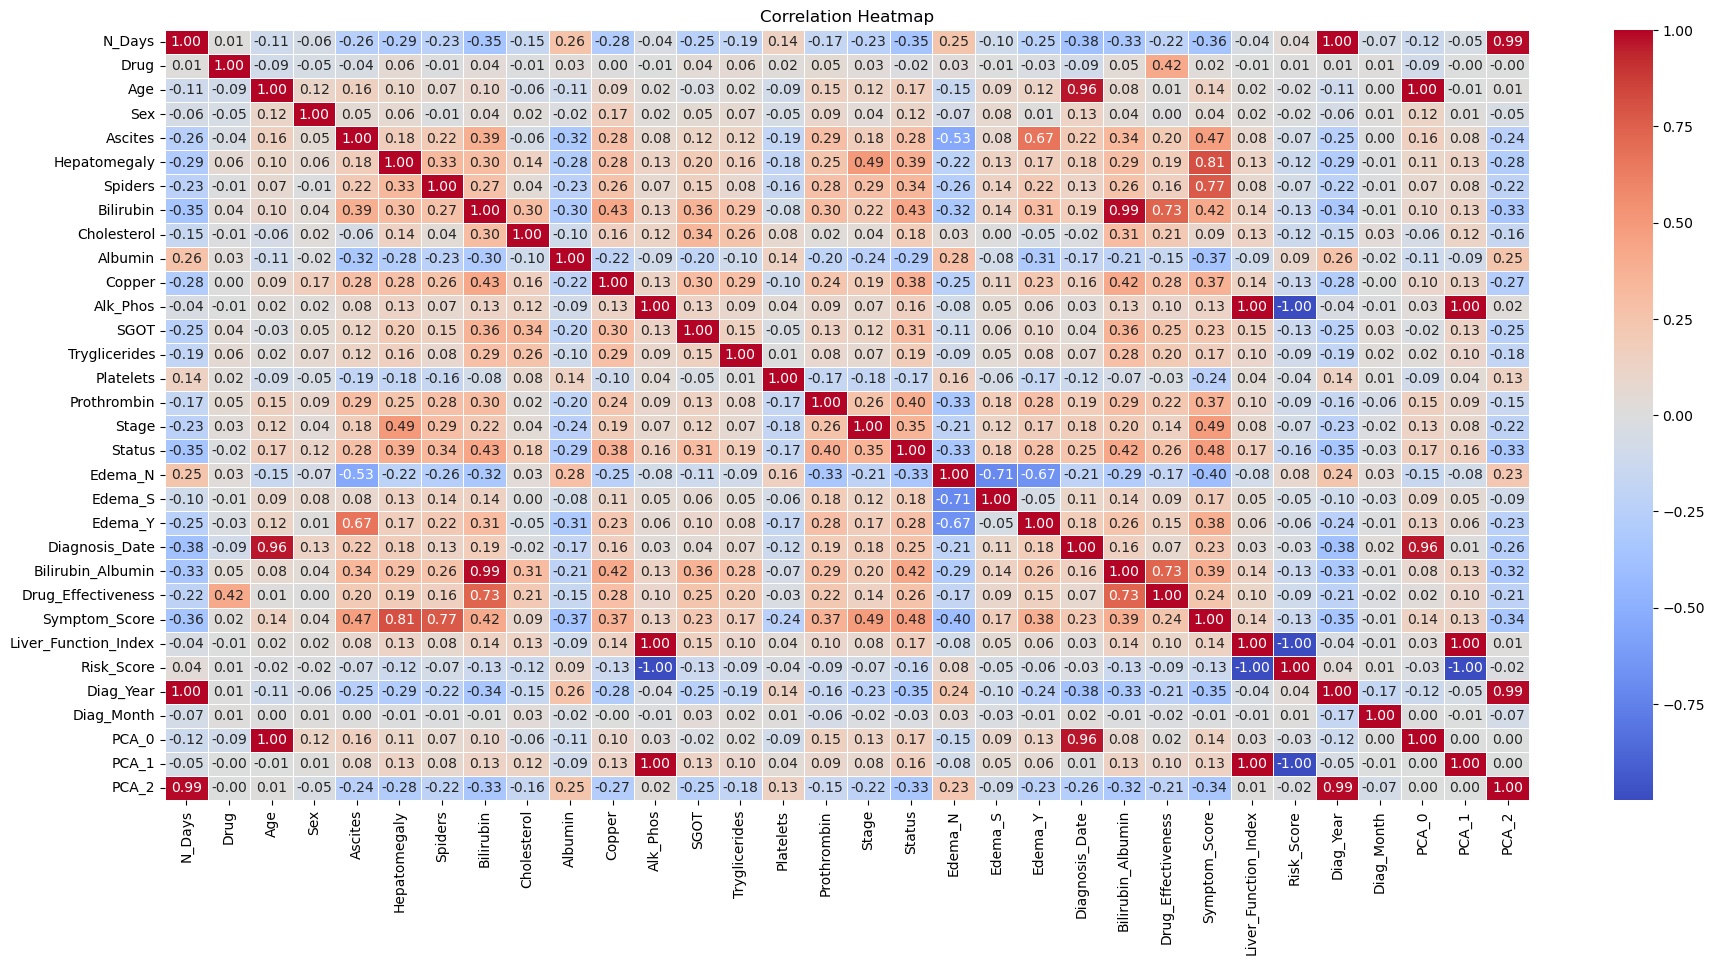

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,Edema_N,Edema_S,Edema_Y,Diagnosis_Date,Bilirubin_Albumin,Drug_Effectiveness,Symptom_Score,Liver_Function_Index,Risk_Score,Diag_Year,Diag_Month,PCA_0,PCA_1,PCA_2
N_Days,1.000000,0.008196,-0.108667,-0.059637,-0.257158,-0.292202,-0.227672,-0.348317,-0.149221,0.260576,-0.281657,-0.037126,-0.246056,-0.186063,0.141072,-0.167650,-0.234027,-0.354201,0.249118,-0.101325,-0.246366,-0.377489,-0.331868,-0.217036,-0.357210,-0.044045,0.036479,0.995428,-0.071975,-1.192405e-01,-5.169795e-02,9.915020e-01
Drug,0.008196,1.000000,-0.092469,-0.048312,-0.039932,0.057891,-0.009500,0.038120,-0.007905,0.025939,0.003567,-0.006997,0.044991,0.056080,0.017255,0.047110,0.027583,-0.017846,0.026557,-0.007462,-0.029788,-0.088402,0.045550,0.419625,0.019519,-0.005716,0.007080,0.007002,0.012627,-9.247548e-02,-4.504719e-03,-3.073531e-03
Age,-0.108667,-0.092469,1.000000,0.116660,0.155433,0.104870,0.067776,0.095644,-0.063450,-0.109105,0.092302,0.019206,-0.027168,0.017223,-0.091167,0.149706,0.122762,0.165146,-0.151561,0.087179,0.122941,0.961551,0.077321,0.014668,0.136965,0.018596,-0.019037,-0.107571,0.003671,9.999197e-01,-7.428394e-03,1.026602e-02
Sex,-0.059637,-0.048312,0.116660,1.000000,0.050593,0.063987,-0.014232,0.039520,0.020325,-0.016835,0.167860,0.015626,0.048822,0.067084,-0.050008,0.086025,0.036336,0.116279,-0.065645,0.077185,0.011643,0.125148,0.043309,0.004513,0.043611,0.016914,-0.015553,-0.060238,0.013670,1.172390e-01,1.340319e-02,-4.571382e-02
Ascites,-0.257158,-0.039932,0.155433,0.050593,1.000000,0.179017,0.217205,0.389601,-0.056195,-0.324745,0.281067,0.075531,0.122410,0.119118,-0.186914,0.293001,0.176360,0.276145,-0.531426,0.079854,0.669391,0.215834,0.335159,0.199052,0.472217,0.079152,-0.074822,-0.254264,0.002584,1.584654e-01,7.551285e-02,-2.363227e-01
Hepatomegaly,-0.292202,0.057891,0.104870,0.063987,0.179017,1.000000,0.326065,0.299096,0.139901,-0.276513,0.277968,0.125119,0.203088,0.156714,-0.182450,0.249729,0.493440,0.394766,-0.218814,0.133810,0.169108,0.178414,0.289757,0.188619,0.810631,0.130475,-0.124596,-0.287614,-0.011106,1.086458e-01,1.273844e-01,-2.759218e-01
Spiders,-0.227672,-0.009500,0.067776,-0.014232,0.217205,0.326065,1.000000,0.269714,0.042364,-0.227934,0.264919,0.073468,0.148540,0.080355,-0.163374,0.279110,0.291345,0.336787,-0.260428,0.142852,0.218582,0.126033,0.259911,0.157431,0.766972,0.077554,-0.072983,-0.223891,-0.010516,7.058637e-02,7.556314e-02,-2.176416e-01
Bilirubin,-0.348317,0.038120,0.095644,0.039520,0.389601,0.299096,0.269714,1.000000,0.297195,-0.298341,0.428185,0.128913,0.361408,0.285268,-0.080170,0.301627,0.215236,0.433973,-0.324676,0.143345,0.309178,0.185322,0.988966,0.726708,0.416590,0.139785,-0.126978,-0.343348,-0.006802,1.000194e-01,1.326954e-01,-3.342667e-01
Cholesterol,-0.149221,-0.007905,-0.063450,0.020325,-0.056195,0.139901,0.042364,0.297195,1.000000,-0.096357,0.158589,0.117816,0.336170,0.260758,0.076563,0.018393,0.041928,0.184056,0.032686,0.001908,-0.048368,-0.017882,0.309488,0.211679,0.091170,0.126697,-0.117262,-0.150849,0.034433,-6.116104e-02,1.235753e-01,-1.567527e-01
Albumin,0.260576,0.025939,-0.109105,-0.016835,-0.324745,-0.276513,-0.227934,-0.298341,-0.096357,1.000000,-0.217386,-0.088748,-0.197849,-0.098489,0.138799,-0.201393,-0.240962,-0.292606,0.281423,-0.084261,-0.310188,-0.173622,-0.212781,-0.150235,-0.365086,-0.093975,0.088349,0.259791,-0.024044,-1.122954e-01,-9.029875e-02,2.452243e-01


In [32]:
corr_heatmap(train_df_mod)

In [33]:
train_df_mod.columns

Index(['N_Days', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders',
       'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT',
       'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage', 'Status',
       'Edema_N', 'Edema_S', 'Edema_Y', 'Diagnosis_Date', 'Age_Years',
       'Age_Group', 'Bilirubin_Albumin', 'Drug_Effectiveness', 'Symptom_Score',
       'Symptom_Score_000FalseFalseTrue', 'Symptom_Score_000FalseTrueFalse',
       'Symptom_Score_000TrueFalseFalse', 'Symptom_Score_001FalseFalseTrue',
       'Symptom_Score_001FalseTrueFalse', 'Symptom_Score_001TrueFalseFalse',
       'Symptom_Score_010FalseFalseTrue', 'Symptom_Score_010FalseTrueFalse',
       'Symptom_Score_010TrueFalseFalse', 'Symptom_Score_011FalseFalseTrue',
       'Symptom_Score_011FalseTrueFalse', 'Symptom_Score_011TrueFalseFalse',
       'Symptom_Score_100FalseFalseTrue', 'Symptom_Score_100FalseTrueFalse',
       'Symptom_Score_100TrueFalseFalse', 'Symptom_Score_101FalseFalseTrue',
       'S

In [34]:
# All
# FEATS = df_train_mod.drop(LABEL, axis=1).columns.tolist()
# Some
# FEATS = ['Platelets', 'Copper', 'Alk_Phos', 'Diagnosis_Date', 'SGOT', 'Age', 'N_Days', 'Cholesterol', 
#          'Tryglicerides', 'Albumin', 'Bilirubin', 'Prothrombin', 'Symptom_Score', 'Stage', 'Drug', 
#          'Hepatomegaly', 'Spiders', 'Sex', 'Edema_N', 'Edema_S', 'Edema_Y']
FEATS = ['Platelets', 'Copper', 'Alk_Phos', 'Diagnosis_Date', 'SGOT', 'Age', 'N_Days', 'Cholesterol', 
         'Tryglicerides', 'Albumin', 'Bilirubin', 'Prothrombin', 'Symptom_Score', 'Stage']

# Columns to exclude
# exlcude_columns = ['Edema_N', 'Platelets', 'Albumin', 'N_Days', 'Diag_year', 'Risk_Score', 'Diag_Month', 'PCA_0','PCA_1','PCA_2','PCA_3', 'Status']
exlcude_columns = ['Edema_N', 'Platelets', 'Albumin', 'N_Days', 'Diag_year', 'Risk_Score', 'Diag_Month', 'PCA_0','PCA_1','PCA_2','PCA_3', 'Status', 'Age_Group',
                   'Spiders', 'Hepatomegaly','Symptom_Score', 'Drug_Effectiveness', 'Stage', 'Sex', 'Symptom_Score_000FalseFalseTrue', 'Symptom_Score_000FalseTrueFalse',
                   'Symptom_Score_000TrueFalseFalse', 'Symptom_Score_001FalseFalseTrue',
                   'Symptom_Score_001FalseTrueFalse', 'Symptom_Score_001TrueFalseFalse',
                   'Symptom_Score_010FalseFalseTrue', 'Symptom_Score_010FalseTrueFalse',
                   'Symptom_Score_010TrueFalseFalse', 'Symptom_Score_011FalseFalseTrue',
                   'Symptom_Score_011FalseTrueFalse', 'Symptom_Score_011TrueFalseFalse',
                   'Symptom_Score_100FalseFalseTrue', 'Symptom_Score_100FalseTrueFalse',
                   'Symptom_Score_100TrueFalseFalse', 'Symptom_Score_101FalseFalseTrue',
                   'Symptom_Score_101FalseTrueFalse', 'Symptom_Score_101TrueFalseFalse',
                   'Symptom_Score_110FalseFalseTrue', 'Symptom_Score_110FalseTrueFalse',
                   'Symptom_Score_110TrueFalseFalse', 'Symptom_Score_111FalseFalseTrue',
                   'Symptom_Score_111FalseTrueFalse', 'Symptom_Score_111TrueFalseFalse',
                   'Ascites', 'Drug', 'Edema_Y','PCA_0', 'PCA_1', 'PCA_2', 'PCA_3']
FEATS2 = list(set(train_df_mod)-set(exlcude_columns))

FEATS_PCA = ['PCA_0','PCA_1','PCA_2']

# FEATS = FEATS + pca_c_names
# FEATS = sel_feats.tolist()
print(f"Number of feats: {len(FEATS)}")
print(f"Features used: {FEATS}")

print(f"\nNumber of feats 2: {len(FEATS2)}")
print(f"Features used 2: {FEATS2}")



Number of feats: 14
Features used: ['Platelets', 'Copper', 'Alk_Phos', 'Diagnosis_Date', 'SGOT', 'Age', 'N_Days', 'Cholesterol', 'Tryglicerides', 'Albumin', 'Bilirubin', 'Prothrombin', 'Symptom_Score', 'Stage']

Number of feats 2: 14
Features used 2: ['Diagnosis_Date', 'Copper', 'Age', 'Tryglicerides', 'Bilirubin_Albumin', 'Cholesterol', 'Diag_Year', 'Edema_S', 'Liver_Function_Index', 'Alk_Phos', 'SGOT', 'Prothrombin', 'Bilirubin', 'Age_Years']


In [35]:
# Just use the selected features
df_train_final = train_df_mod[FEATS + [LABEL]]
df_test_final = test_df_mod[FEATS+[LABEL]]
test_real_df_final = test_df_real_mod[FEATS]

df_train_final2 = train_df_mod[FEATS2 + [LABEL]]
df_test_final2 = test_df_mod[FEATS2+[LABEL]]
test_real_df_final2 = test_df_real_mod[FEATS2]

df_train_final_pca = train_df_mod[FEATS_PCA + [LABEL]]
df_test_final_pca = test_df_mod[FEATS_PCA+[LABEL]]
test_real_df_final_pca = test_df_real_mod[FEATS_PCA]



In [36]:
# Resample data
X = df_train_final.drop('Status', axis=1)
y = df_train_final['Status']


In [37]:
y.value_counts()

Status
0    3475
2    1865
1     193
Name: count, dtype: int64

### Oversampling and Undersampling

In [38]:
over_strategy1 = {0:3475, 1:800, 2: 1865}
under_strategy1 = {0:1865, 1:800, 2: 1865}
over = SMOTE(sampling_strategy=over_strategy1)
under = RandomUnderSampler(sampling_strategy=under_strategy1)
X_res, y_res = over.fit_resample(X, y)
# X_res2, y_res2 = over.fit_resample(X2, y2)

X_res, y_res = under.fit_resample(X_res, y_res)
# X_res2, y_res2 = under.fit_resample(X2, y2)

In [39]:
y_res.value_counts()

Status
0    1865
2    1865
1     800
Name: count, dtype: int64

In [40]:
df_train_final = pd.concat([X_res, y_res], axis=1)
# df_test_final = pd.concat([X_res2, y_res2], axis=1)

## Creación de Modelo

In [41]:
xgb_cl = xgb.XGBClassifier()
rf_cl = RandomForestClassifier()
gb_cl = GradientBoostingClassifier()

models = [
    {"name": "rf_cl", "model": rf_cl, "feats": FEATS},
    {"name": "xgb_cl", "model": xgb_cl, "feats": FEATS},
    {"name": "gb_cl", "model": gb_cl, "feats": FEATS},
]

### Selección de Hiperparametros

#### Randomized Search

In [42]:
# Local optuna optimization test (cross val score: .4129666179319006), 21 FEATS
xgb_params = {'objective': 'multi_logloss', 'early_stopping_rounds': 50, 'max_depth': 9, 'min_child_weight': 8, 'learning_rate': 0.0337716365315986, 'n_estimators': 733, 'subsample': 0.6927955384688348, 'colsample_bytree': 0.1234702658812108, 'reg_alpha': 0.18561628377665318, 'reg_lambda': 0.5565488299127089, 'random_state': 42}
xgb_params2 = {'objective': 'multi_logloss', 'max_depth': 9, 'min_child_weight': 8, 'n_estimators': 733, 'subsample': 0.6927955384688348, 'colsample_bytree': 0.1234702658812108, 'reg_alpha': 0.18561628377665318, 'reg_lambda': 0.5565488299127089, 'random_state': 42}

In [43]:
random_forest_params = {
    'n_estimators': [10, 50, 100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

xgboost_params = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4]
}

gradient_boosting_params = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0]
}

In [44]:


rs_params = [random_forest_params, xgboost_params, gradient_boosting_params]

best_params_rs = {}

In [45]:
X_train = df_train_final.drop('Status', axis=1)
y_train = df_train_final['Status']

In [46]:
# Load best params
joblib_best_params_rs = joblib.load('best_params_rs.joblib')

In [47]:
if joblib_best_params_rs is None:
    # Create Randomized Search for each algorithm
    for i, model in enumerate(models): 
        print(model['name'])
        rs = RandomizedSearchCV(estimator=model['model'], param_distributions=rs_params[i], n_iter=20, cv=3, random_state=42, n_jobs=-1)
        rs.fit(X_train, y_train)
        best_params_rs[model['name']] = rs.best_params_

    # Save best params locally
    joblib.dump(best_params_rs, 'best_params_rs.joblib')

In [48]:
if joblib_best_params_rs is not None:
    best_params_rs = joblib_best_params_rs

In [49]:
best_params_rs

{'rf_cl': {'n_estimators': 200,
  'min_samples_split': 5,
  'min_samples_leaf': 1,
  'max_features': 'auto',
  'max_depth': None,
  'bootstrap': False},
 'xgb_cl': {'subsample': 0.9,
  'n_estimators': 300,
  'min_child_weight': 5,
  'max_depth': 7,
  'learning_rate': 0.2,
  'gamma': 0.2,
  'colsample_bytree': 0.9},
 'gb_cl': {'subsample': 0.9,
  'n_estimators': 100,
  'min_samples_split': 5,
  'min_samples_leaf': 4,
  'max_depth': 9,
  'learning_rate': 0.1}}

#### Grid Search

In [50]:
# {'rf_cl': {'n_estimators': 200,
#   'min_samples_split': 5,
#   'min_samples_leaf': 1,
#   'max_features': 'auto',
#   'max_depth': None,
#   'bootstrap': False},

 

random_forest_params = {
    'n_estimators': [200, 300, 400],
    'max_features': ['auto'],
    'max_depth': [None, 70, 100],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [0, 1],
    'bootstrap': [False]
}

#  'xgb_cl': {'subsample': 0.9,
#   'n_estimators': 300,
#   'min_child_weight': 5,
#   'max_depth': 7,
#   'learning_rate': 0.2,
#   'gamma': 0.2,
#   'colsample_bytree': 0.9},

xgboost_params = {
    'learning_rate': [0.2, 0.4],
    'n_estimators': [300, 400, 500],
    'max_depth': [7],
    'min_child_weight': [5, 6, 7],
    'subsample': [0.9],
    'colsample_bytree': [0.9],
    'gamma': [0.2]
}

# 'gb_cl': {'subsample': 0.9,
#   'n_estimators': 100,
#   'min_samples_split': 5,
#   'min_samples_leaf': 4,
#   'max_depth': 9,
#   'learning_rate': 0.1}}

gradient_boosting_params = {
    'n_estimators': [75, 100, 150],
    'learning_rate': [0.1, 0.15],
    'max_depth': [7],
    'min_samples_split': [5],
    'min_samples_leaf': [4, 5, 6],
    'subsample': [0.9]
}

gs_params = [random_forest_params, xgboost_params, gradient_boosting_params]

gs_best_estimators = {}
gs_best_params = {}

In [51]:
gs_params

[{'n_estimators': [200, 300, 400],
  'max_features': ['auto'],
  'max_depth': [None, 70, 100],
  'min_samples_split': [2, 5, 10],
  'min_samples_leaf': [0, 1],
  'bootstrap': [False]},
 {'learning_rate': [0.2, 0.4],
  'n_estimators': [300, 400, 500],
  'max_depth': [7],
  'min_child_weight': [5, 6, 7],
  'subsample': [0.9],
  'colsample_bytree': [0.9],
  'gamma': [0.2]},
 {'n_estimators': [75, 100, 150],
  'learning_rate': [0.1, 0.15],
  'max_depth': [7],
  'min_samples_split': [5],
  'min_samples_leaf': [4, 5, 6],
  'subsample': [0.9]}]

In [52]:
# Load best estimators & params
joblib_best_estimators_gs = joblib.load('best_estimators_gs.joblib')
joblib_best_params_gs = joblib.load('best_params_gs.joblib')

In [53]:
if joblib_best_estimators_gs and joblib_best_params_gs is None:
    for i, model in enumerate(models):
        print(model['name'])
        gs = GridSearchCV(estimator=model['model'], param_grid=gs_params[i], cv=3, n_jobs=-1, verbose=0)
        gs.fit(X_train, y_train)
        gs_best_estimators[model['name']] = gs.best_estimator_
        gs_best_params[model['name']] = gs.best_params_

    # Save best estimators & params locally
    joblib.dump(gs_best_estimators, 'best_estimators_gs.joblib')
    joblib.dump(gs_best_params, 'best_params_gs.joblib')


In [54]:
if joblib_best_estimators_gs and joblib_best_params_gs is not None:
    gs_best_estimators = joblib_best_estimators_gs
    gs_best_params = joblib_best_params_gs

### Entrenamiento de Modelos

#### Simple approach

In [55]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

X = df_train_final.drop('Status', axis=1)
y = df_train_final['Status']

train_scores = cross_val_score(rf_cl, X, y, scoring='roc_auc_ovo', cv=cv, n_jobs=-1)


In [56]:
print('Mean ROC AUC training:%.3f' % np.mean(train_scores))


Mean ROC AUC training:0.941


In [57]:
rf_cl.fit(X, y)

RandomForestClassifier()

In [58]:
y_pred_train = rf_cl.predict(df_train_final[FEATS])
y_pred_test = rf_cl.predict(df_test_final[FEATS])

In [59]:
print(f"Clssification report Training: ")
print(classification_report(df_train_final[LABEL],y_pred_train))
print(f"\nClassification Report Testing: ")
print(classification_report(df_test_final[LABEL],y_pred_test))
print()


Clssification report Training: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1865
           1       1.00      1.00      1.00       800
           2       1.00      1.00      1.00      1865

    accuracy                           1.00      4530
   macro avg       1.00      1.00      1.00      4530
weighted avg       1.00      1.00      1.00      4530


Classification Report Testing: 
              precision    recall  f1-score   support

           0       0.87      0.84      0.85      1490
           1       0.31      0.21      0.25        82
           2       0.71      0.77      0.74       800

    accuracy                           0.80      2372
   macro avg       0.63      0.61      0.61      2372
weighted avg       0.79      0.80      0.79      2372




#### Complex Approach

In [60]:
rf_class_weights = {0:1, 1:2, 2:1}

# Define classifiers with best params
xgb_cl = xgb.XGBClassifier(**gs_best_params['xgb_cl'])
rf_cl = RandomForestClassifier(**gs_best_params['rf_cl'])
gb_cl = GradientBoostingClassifier(**gs_best_params['gb_cl'])

# Define base classifiers for stacking model
base_cl_stacking = [
    ('dt', DecisionTreeClassifier(random_state=42)),
    ('gb', GradientBoostingClassifier()),
    ('svc', SVC(probability=True))
]

# Define meta-model for stacking model
meta_cl = xgb.XGBClassifier(**gs_best_params['xgb_cl'])

# Create Stacking classifier
stacking_cl = StackingClassifier(estimators=base_cl_stacking, final_estimator=meta_cl)

models = [
    {"name": "xgb_cl", "model": xgb_cl, "feats": FEATS},
    {"name": "rf_cl", "model": rf_cl, "feats": FEATS},
    {"name": "gb_cl", "model": gb_cl, "feats": FEATS},
    {"name": "stack_cl", "model": stacking_cl, "feats": FEATS},
]

In [61]:
# Load models, train_scores & val_scores locally
joblib_models = joblib.load('models.joblib')
joblib_train_scores = joblib.load('train_scores.joblib')
joblib_val_scores = joblib.load('val_scores.joblib')

In [62]:
if joblib_models is None and joblib_train_scores is None and joblib_val_scores is None:
    # Validate all models and store model, training scores and validation scores
    models, train_scores, val_scores = validate_models(models=models, 
                                                    data=df_train_final,
                                                    label=LABEL, 
                                                    n_splits=10,
                                                    n_repeats=3)

    # Save models, train_scores & val_scores locally
    joblib.dump(models, 'models.joblib')
    joblib.dump(train_scores, 'train_scores.joblib')
    joblib.dump(val_scores, 'val_scores.joblib')

In [63]:
if joblib_models is not None and joblib_val_scores is not None and joblib_train_scores is not None:
    models = joblib_models
    val_scores = joblib_val_scores
    train_scores = joblib_train_scores

In [64]:
val_scores

,xgb_cl,rf_cl,gb_cl,stack_cl
0,0.438523,0.430308,0.443033,0.601190
1,0.434743,0.427889,0.416142,0.508819
2,0.522793,0.558437,0.509126,0.616391
3,0.539731,0.496631,0.517696,0.652536
4,0.437195,0.521524,0.424066,0.527986
5,0.483578,0.460824,0.464141,0.575852
6,0.470831,0.447734,0.433503,0.621370
7,0.459475,0.422600,0.431121,0.574353
8,0.574815,0.504973,0.555484,0.713132
9,0.507331,0.465035,0.495343,0.555952


### Evaluación de Modelo(s)

#### Graphs

In [65]:
# mean LOG LOSS score for each classifier
for column in train_scores.columns:
    print(f"{column}\t-> LOG LOSS score TRAINING:\t{np.mean(train_scores[column]):.2f}")
    print(f"{column}\t-> LOG LOSS score VALIDATION:\t{np.mean(val_scores[column]):.2f}")

xgb_cl	-> LOG LOSS score TRAINING:	0.03
xgb_cl	-> LOG LOSS score VALIDATION:	0.49
rf_cl	-> LOG LOSS score TRAINING:	0.00
rf_cl	-> LOG LOSS score VALIDATION:	0.48
gb_cl	-> LOG LOSS score TRAINING:	0.02
gb_cl	-> LOG LOSS score VALIDATION:	0.47
stack_cl	-> LOG LOSS score TRAINING:	0.30
stack_cl	-> LOG LOSS score VALIDATION:	0.60


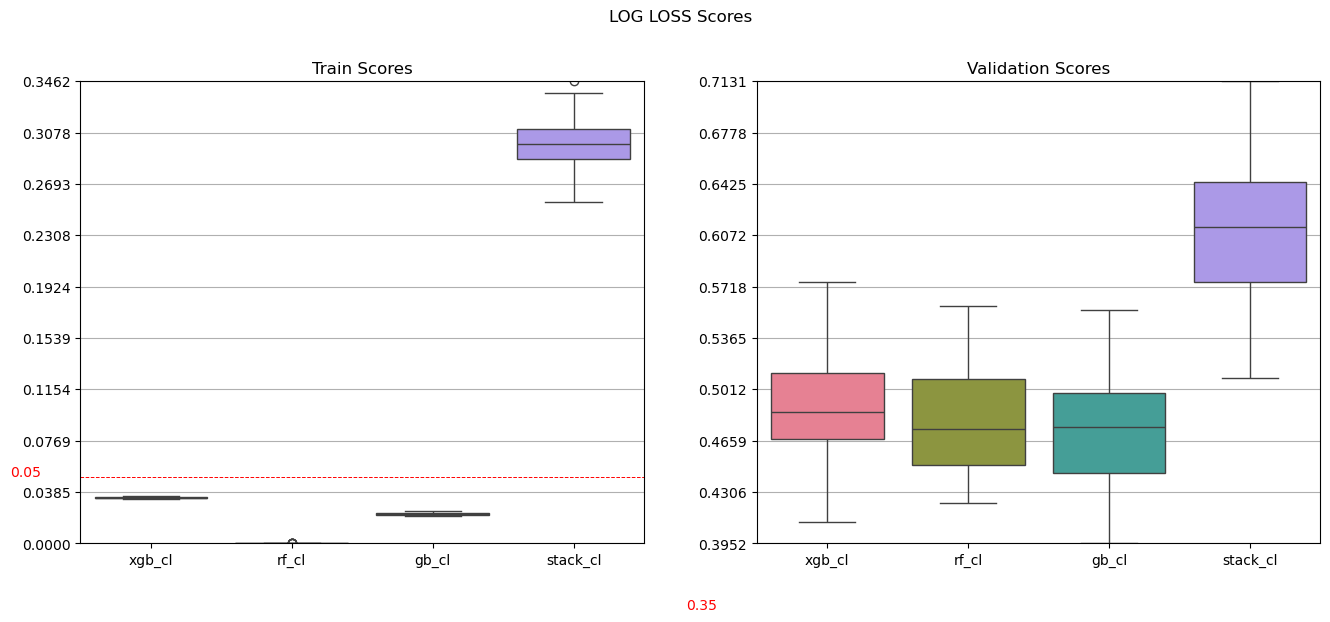

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

eps = .05
hl_train = .05
hl_val = .35
min_score_train = train_scores.min().min()
max_score_train = train_scores.max().max()
max_score_val = val_scores.max().max()
min_score_val = val_scores.min().min()
def calculate_ticks_train(min_score, max_score, num_ticks=10):
    return np.linspace(min_score, max_score, num_ticks)

def calculate_ticks_val(min_score, max_score, num_ticks=10):
    return np.linspace(min_score, max_score, num_ticks)

ticks_train = calculate_ticks_train(min_score_train, max_score_train)
ticks_val = calculate_ticks_val(min_score_val, max_score_val)


_ = sns.boxplot(train_scores, ax=axes[0])
_ = axes[0].set_title('Train Scores')
_ = axes[0].set_ylim(min_score_train, max_score_train)
_ = axes[0].set_yticks(ticks_train)
_ = axes[0].yaxis.grid(True)
_ = axes[0].axhline(y=hl_train, color='r', linestyle='--', lw=.7)
_ = axes[0].text(-1, hl_train, f"{hl_train}", c="red")

_ = sns.boxplot(val_scores, ax=axes[1])
_ = axes[1].set_title('Validation Scores')
_ = axes[1].set_ylim(min_score_val, max_score_val)
_ = axes[1].set_yticks(ticks_val)
_ = axes[1].yaxis.grid(True)
_ = axes[1].axhline(y=hl_val, color='r', linestyle='--', lw=.7)
_ = axes[1].text(-1, hl_val, f"{hl_val}", c="red")

fig.suptitle("LOG LOSS Scores", y=1)  # Add a common title above the subplots
plt.show()


       XGB Train  XGB Validation      RF Train  RF Validation   GB Train  \
count  30.000000       30.000000  3.000000e+01      30.000000  30.000000   
mean    0.034223        0.489466  2.720224e-04       0.480670   0.022031   
std     0.000398        0.039255  1.383364e-04       0.038927   0.001058   
min     0.033510        0.409572  4.440892e-16       0.422600   0.020144   
25%     0.033901        0.466659  3.400281e-04       0.449140   0.021302   
50%     0.034224        0.485601  3.400281e-04       0.474032   0.022045   
75%     0.034445        0.512110  3.400281e-04       0.508315   0.022537   
max     0.035212        0.574815  3.400281e-04       0.558437   0.024332   

       GB Validation  
count      30.000000  
mean        0.473415  
std         0.039454  
min         0.395238  
25%         0.443638  
50%         0.475065  
75%         0.498596  
max         0.555484  


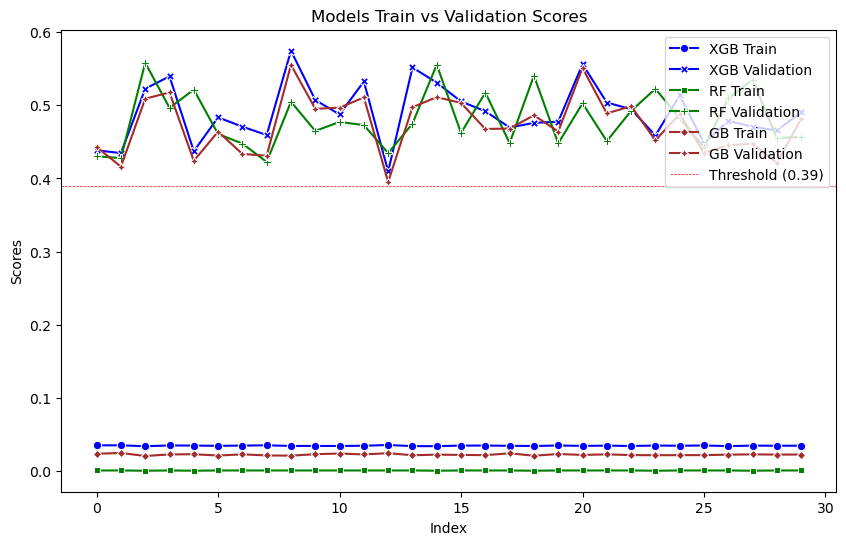

In [67]:
# Assuming `train_scores` and `val_scores` are DataFrames with scores for each model

# Separate the scores for xgb_cl and rf_cl models
xgb_train_scores = train_scores["xgb_cl"]
xgb_val_scores = val_scores["xgb_cl"]
rf_train_scores = train_scores["rf_cl"]
rf_val_scores = val_scores["rf_cl"]
gb_train_scores = train_scores["gb_cl"]
gb_val_scores = val_scores["gb_cl"]

# Print results in DataFrame
model_res = pd.concat([xgb_train_scores.describe(), xgb_val_scores.describe(), rf_train_scores.describe(), rf_val_scores.describe(), gb_train_scores.describe(),gb_val_scores.describe()], axis=1)
model_res.columns = ['XGB Train', 'XGB Validation', 'RF Train', 'RF Validation', 'GB Train', 'GB Validation']
print(model_res)

# Plot results as lineplot
plt.figure(figsize=(10, 6))
_ = sns.lineplot(data=pd.concat([xgb_train_scores, xgb_val_scores, rf_train_scores, rf_val_scores, gb_train_scores, gb_val_scores], keys=["XGB Train", "XGB Validation", "RF Train", "RF Validation", 'GB Train', 'GB Validation'], axis=1), markers=True, dashes=False, palette=["blue", "blue", "green", "green", 'brown','brown'])
plt.axhline(y=0.39, color='r', linestyle='--', lw=.5, label='Threshold (0.39)')

# Set the same color for both lines in the legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(loc='upper right')

plt.title('Models Train vs Validation Scores')
plt.xlabel('Index')
plt.ylabel('Scores')
plt.show()


In [68]:
class MyAvgVoting(BaseEstimator, ClassifierMixin):
    """A basic voting method that just averages all estimator predictions and 
    predicts the class with the highest vote."""
    def __init__(self, estimators, weighted=False):
        self.estimators = estimators
        # Whether to average according to validation scores
        self.weighted = weighted

    def fit(self, X, y):
        for _, est in self.estimators:
            est["model"].fit(X, y)
        return self
    
    def create_avg_prob_predictions(self, X):
        predictions = np.array([est["model"].predict_proba(X) for est in self.estimators])
        if self.weighted:
            # Note: we need the inverse of the val_score since lower values are "better"
            weights = [{"name": est["name"], "value": 1/est["avg_val_score"]} for est in self.estimators]
            print(f"Weights are:\n{pd.DataFrame(weights)}")
            return np.average(predictions, axis=0, weights=[w["value"] for w in weights])
        return np.average(predictions, axis=0)
            
    def predict(self, X):
        avg_predictions = self.create_avg_prob_predictions(X)
        return np.argmax(avg_predictions, axis=1)

    def predict_proba(self, X):
        avg_predictions = self.create_avg_prob_predictions(X)
        return avg_predictions

    def score(self, X, y):
        pass

voting_ests = models
voting_clf = MyAvgVoting(voting_ests, weighted=False) 
# no fitting needed

#### Classification Report

##### Best Parameters each model

In [69]:
# Classification report for all models in models
for model in models:
    y_pred_train = model['model'].predict(df_train_final[model['feats']])
    y_pred_test = model['model'].predict(df_test_final[model['feats']])
    print(f"{model['name']}(): ")
    print(f"Classification report Training: ")
    print(classification_report(df_train_final[LABEL],y_pred_train))
    print(f"\nClassification Report Testing: ")
    print(classification_report(df_test_final[LABEL],y_pred_test))
    print()


xgb_cl(): 
Classification report Training: 
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1865
           1       0.94      0.81      0.87       800
           2       0.87      0.93      0.90      1865

    accuracy                           0.89      4530
   macro avg       0.90      0.88      0.89      4530
weighted avg       0.89      0.89      0.89      4530


Classification Report Testing: 
              precision    recall  f1-score   support

           0       0.95      0.88      0.91      1490
           1       0.70      0.78      0.74        82
           2       0.81      0.91      0.86       800

    accuracy                           0.89      2372
   macro avg       0.82      0.86      0.84      2372
weighted avg       0.89      0.89      0.89      2372


rf_cl(): 
Classification report Training: 
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      1865
        

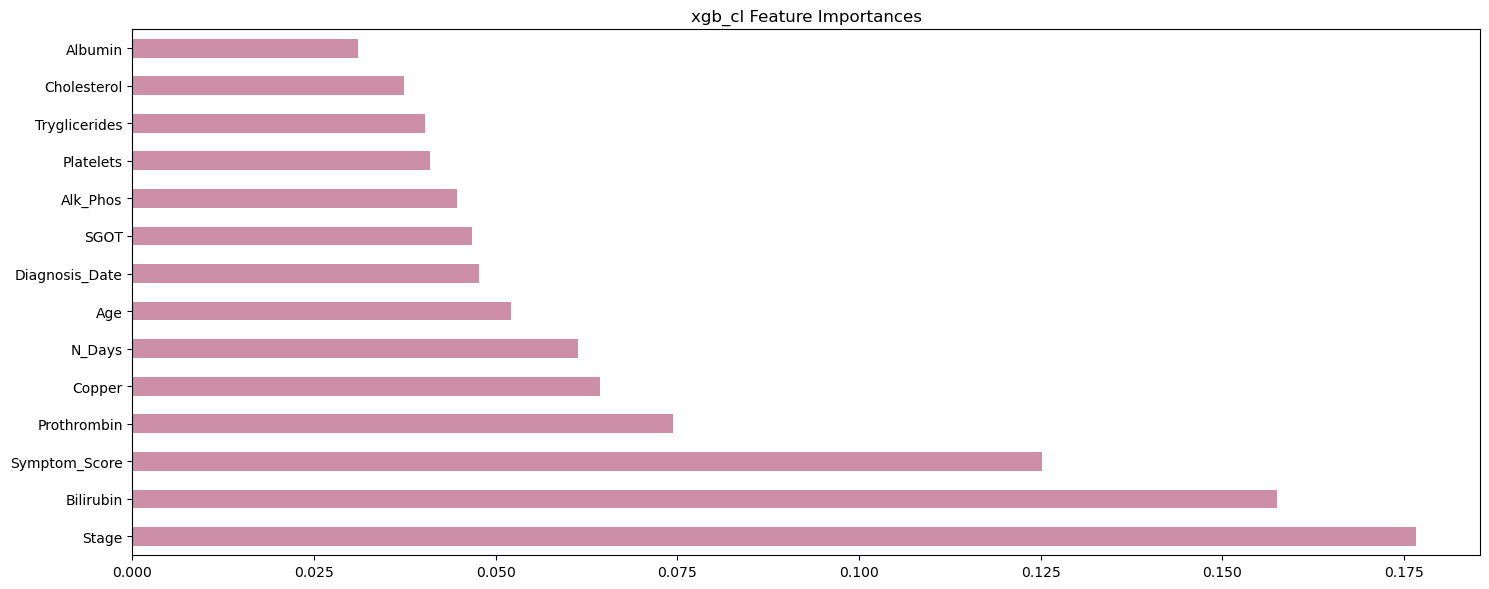

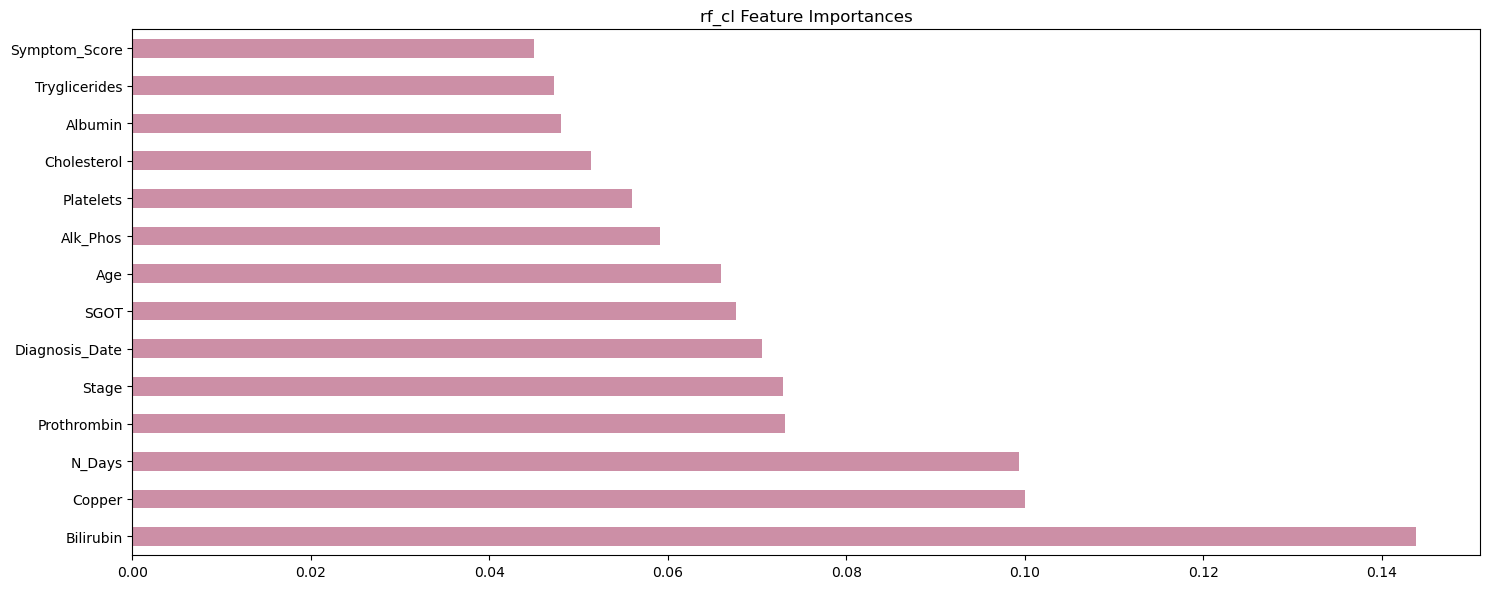

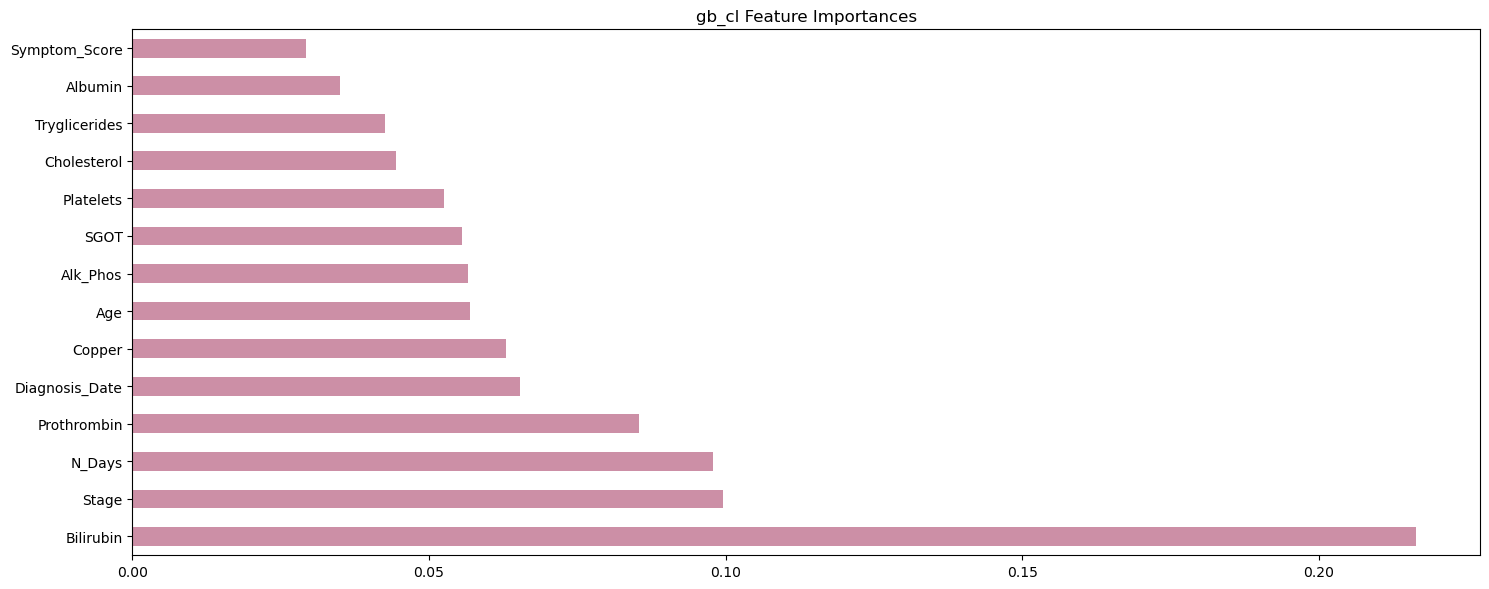

AttributeError: 'StackingClassifier' object has no attribute 'feature_importances_'

In [70]:
for model in models:
    feat_importances = pd.Series(model['model'].feature_importances_, index=df_train_final[FEATS].columns)

    # Plotting both feature importances in subplots
    fig, axes = plt.subplots(1, 1, figsize=(15, 6))

    feat_importances.nlargest(20).plot(kind='barh', title=f"{model['name']} Feature Importances")

    plt.tight_layout()
    plt.show()
    # print(f"Total sorted  importances: {feat_importances.nlargest(99).index.tolist()}")